In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
path_ds = "/content/drive/MyDrive/Colab Notebooks/Text Analysis and Sentiment Analysis/Assignment/cleaned_IMDB_Dataset.csv"
df = pd.read_csv(path_ds)

print(df.shape)

(50000, 2)


In [ ]:
frequencies = df["sentiment"].value_counts()
frequencies.to_frame()

,sentiment
positive,25000
negative,25000


In [ ]:
pip install keras==2.12.0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow import keras
from kerastuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
X = df.review
y = df.sentiment

In [ ]:
x_train, x_test, y_train,y_test = train_test_split(X, y, test_size=0.20, random_state= 0 , stratify= y)
print('X_train shape --> ', x_train.shape)
print('y_train shape --> ', y_train.shape)
print('X_test shape --> ', x_test.shape)
print('y_test shape --> ', y_test.shape)

X_train shape -->  (40000,)
y_train shape -->  (40000,)
X_test shape -->  (10000,)
y_test shape -->  (10000,)


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

168143

In [ ]:
max_sequence_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_sequence_len)

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Colab Notebooks/Text Analysis and Sentiment Analysis/Assignment/glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 300 columns
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(168143, 300)

In [ ]:
# Define the model creation function
def create_model(filters=32, kernel_size=7, optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=max_sequence_len, trainable=False))
    model.add(layers.Conv1D(filters, kernel_size, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Conv1D(filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# # Create the Keras classifier
model = KerasClassifier(build_fn=create_model)

<ipython-input-21-d40e9de6683e>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


In [ ]:
# Define the hyperparameters grid
param_grid = {
    'filters': [16, 32, 64],
    'kernel_size': [3, 5, 7],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'sgd'],
}

In [ ]:
# Define the early stopping callback

early_stopping = EarlyStopping(monitor='loss', patience=3)

**CONDUCTING GRID SEARCH FOR THE MODEL.**

In [ ]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, random_state=42)

In [ ]:
# Fit the random search with early stopping
random_result = random_search.fit(X_train, y_train, callbacks=[early_stopping])

313/313 [==============================] - 3s 6ms/step - loss: 0.4448 - accuracy: 0.7864


In [ ]:
# Print the best parameters and score
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.830950 using {'optimizer': 'adam', 'kernel_size': 3, 'filters': 64, 'batch_size': 128}


In [ ]:
# Get the best model and its parameters
best_model = random_result.best_estimator_
best_params = random_result.best_params_


Epoch 1/30
1250/1250 [==============================] - 8s 5ms/step - loss: 0.4179 - accuracy: 0.8059 - val_loss: 0.3628 - val_accuracy: 0.8348
Epoch 2/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3378 - accuracy: 0.8518 - val_loss: 0.3469 - val_accuracy: 0.8480
Epoch 3/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3039 - accuracy: 0.8702 - val_loss: 0.3407 - val_accuracy: 0.8502
Epoch 4/30
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2760 - accuracy: 0.8811 - val_loss: 0.3244 - val_accuracy: 0.8593
Epoch 5/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2463 - accuracy: 0.8981 - val_loss: 0.3309 - val_accuracy: 0.8603
Epoch 6/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.2199 - accuracy: 0.9079 - val_loss: 0.3423 - val_accuracy: 0.8581
Epoch 7/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2005 - accuracy: 0.9190 - val_loss: 0.3647 - val_accuracy

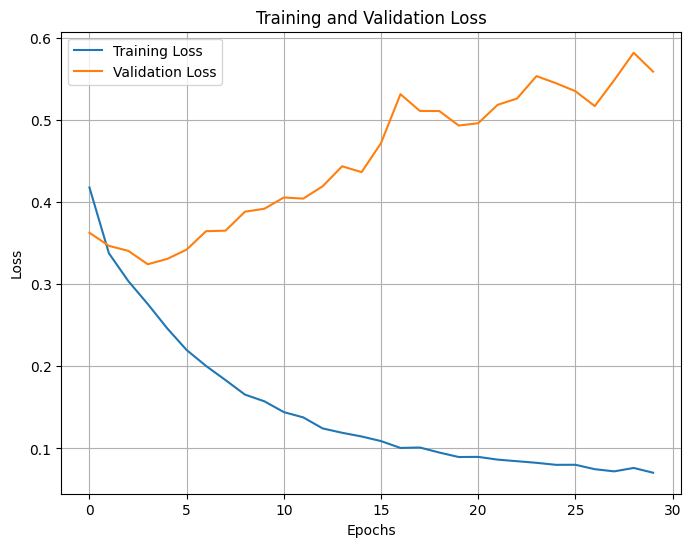

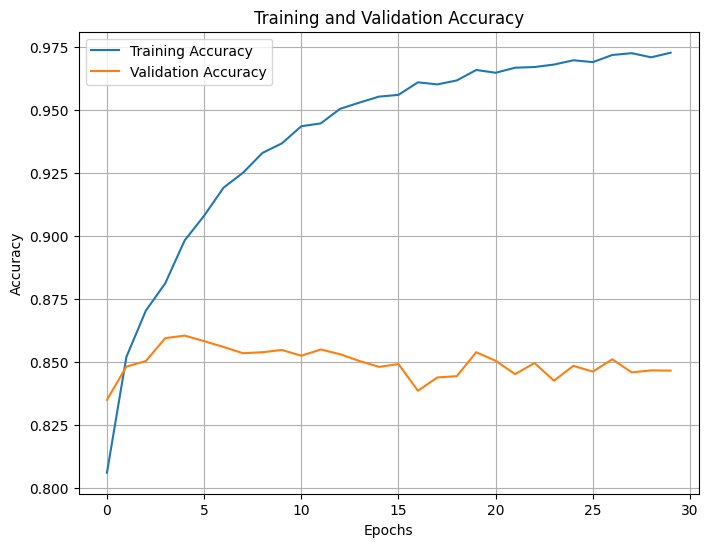

In [ ]:

# Train the best model to obtain the training history
history = best_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Extract loss and accuracy values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.8464
Confusion Matrix:
 [[4077  923]
 [ 613 4387]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      5000
           1       0.83      0.88      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



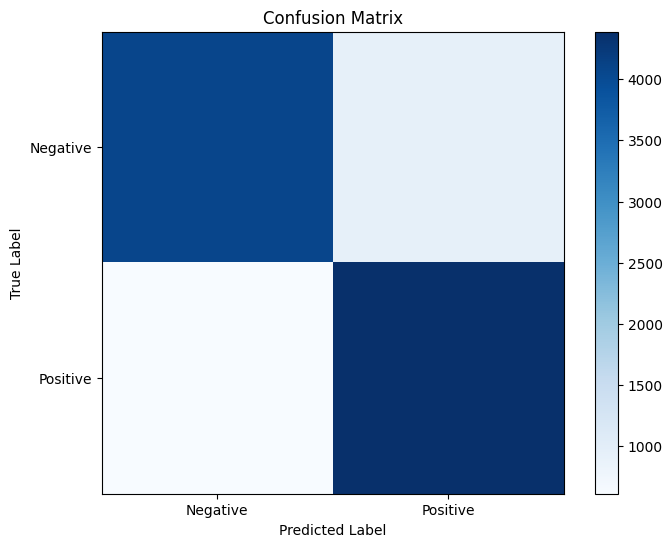

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print classification report
report = classification_report(y_test, y_pred)

# Print accuracy and confusion matrix
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()